In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

if os.path.exists("MSFT.csv"):
    data = pd.read_csv("MSFT.csv", index_col=0)
else: #download data if not found
    data = yf.Ticker("MSFT")
    data = data.history(period="max")
    data.to_csv("MSFT.csv")



# Convert the index to datetime with utc=True
data.index = pd.to_datetime(data.index, utc=True)

# Ensure the index is a DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data = data.set_index(pd.to_datetime(data.index, utc=True))

# Filter data to include only records from 2016 onwards
data = data[data.index.year >= 2010]

# reset the index (the index will be 0,1,2... rather than the date)
# data = data.reset_index()

#volume values are too lage
data['Volume'] = data['Volume'].copy()/10000000

data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
# data.drop(data['Stock Splits'])
data.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04 05:00:00+00:00,23.181753,23.545151,23.159040,23.431589,3.84091
2010-01-05 05:00:00+00:00,23.355880,23.545149,23.196893,23.439157,4.97496
2010-01-06 05:00:00+00:00,23.378592,23.530009,23.106045,23.295315,5.81824
2010-01-07 05:00:00+00:00,23.189330,23.242326,22.856216,23.053057,5.05597
2010-01-08 05:00:00+00:00,22.924343,23.378589,22.894059,23.212032,5.11974
2010-01-11 05:00:00+00:00,23.249884,23.287739,22.803209,22.916771,6.87547
2010-01-12 05:00:00+00:00,22.825930,23.015200,22.644231,22.765364,6.59121
2010-01-13 05:00:00+00:00,22.909207,23.106048,22.719938,22.977345,5.18635
2010-01-14 05:00:00+00:00,22.947057,23.545149,22.909203,23.439157,6.32281


In [22]:
# Define aggregation functions for each column
agg_functions = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}

# Resample the DataFrame to weekly frequency and apply the aggregation functions
data = data.resample('W-Mon').agg(agg_functions)
print(data.head())

                                Open       High        Low      Close  \
Date                                                                    
2010-01-04 00:00:00+00:00  23.181753  23.545151  23.159040  23.431589   
2010-01-11 00:00:00+00:00  23.355880  23.545149  22.803209  22.916771   
2010-01-18 00:00:00+00:00  22.825930  23.651135  22.644231  23.363445   
2010-01-25 00:00:00+00:00  23.280171  23.651139  21.834154  22.197548   
2010-02-01 00:00:00+00:00  22.106699  22.651803  20.940805  21.508610   

                             Volume  
Date                                 
2010-01-04 00:00:00+00:00   3.84091  
2010-01-11 00:00:00+00:00  27.84438  
2010-01-18 00:00:00+00:00  26.09169  
2010-01-25 00:00:00+00:00  33.98895  
2010-02-01 00:00:00+00:00  52.79227  


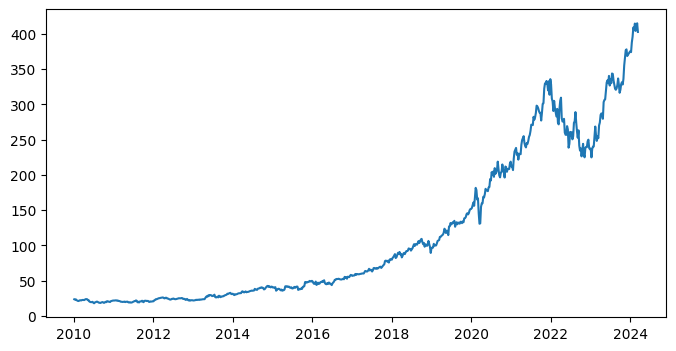

In [23]:
# # Plotting
plt.figure(figsize=(8,4))
plt.plot(data['Close'], label='Closing Price')

In [24]:
# Feature: Moving Averages

data['sma_20'] = data['Close'].rolling(window=20).mean() # 20-day Simple Moving Average
data['ema_12'] = data['Close'].ewm(span=12, adjust=False).mean() # 12-day Exponential Moving Average

# Feature: Rate of Change
data['roc'] = data['Close'].pct_change() * 100 # Percentage change in closing price

# Feature: Bollinger Bands
data['upper_band'], data['lower_band'] = data['Close'].rolling(window=20).mean() + 2 * data['Close'].rolling(window=20).std(), data['Close'].rolling(window=20).mean() - 2 * data['Close'].rolling(window=20).std()

# Feature: Historical Volatility
data['historical_volatility'] = data['Close'].pct_change().rolling(window=20).std() * (252 ** 0.5) # Annualized volatility

# Feature: Price Rate of Change
data['price_roc'] = data['Close'].pct_change()

# Feature Interaction: Volume-Price Interaction
data['volume_price_interaction'] = data['Volume'] * data['Close']

# Feature: Seasonality
data['month'] = data.index.month
data['quarter'] = data.index.quarter

# External Factor: Market Index Movement (Assuming 'market_index' is a separate dataset)
# data['market_index_movement'] = market_index['Close'].pct_change()

# Display the updated DataFrame
data = data.dropna()
data.head()


,Open,High,Low,Close,Volume,sma_20,ema_12,roc,upper_band,lower_band,historical_volatility,price_roc,volume_price_interaction,month,quarter
Date,,,,,,,,,,,,,,,
2010-05-24 00:00:00+00:00,22.058166,22.157492,20.063982,20.071623,39.37364,22.264320,22.232340,-8.816404,24.125719,20.402920,0.510534,-0.088164,790.292852,5,2
2010-05-31 00:00:00+00:00,19.597922,20.331411,18.765105,19.712511,47.89882,22.104107,21.844674,-1.789152,24.257709,19.950505,0.509173,-0.017892,944.206019,5,2
2010-06-07 00:00:00+00:00,19.506229,20.575899,19.284653,19.322857,37.99966,21.902077,21.456702,-1.976685,24.302236,19.501919,0.501087,-0.019767,734.261993,6,2
2010-06-14 00:00:00+00:00,19.292296,19.834772,18.833865,19.483309,37.31100,21.766365,21.153103,0.830374,24.392485,19.140246,0.480173,0.008304,726.941734,6,2
2010-06-21 00:00:00+00:00,19.674319,20.545338,19.666678,19.827131,28.50359,21.682292,20.949108,1.764703,24.447154,18.917429,0.477666,0.017647,565.144421,6,2


In [25]:
data['Open - Close'] = data['Open'] - data['Close']
data['High - Low'] = data['High'] - data['Low']
data = data.dropna()


data['Close Tomorrow'] = (data['Close'].shift(-1) > data['Close']).astype(int)* 2 - 1  # * 2 - 1 ==>   replaces 0 with -1

data.head()

,Open,High,Low,Close,Volume,sma_20,ema_12,roc,upper_band,lower_band,historical_volatility,price_roc,volume_price_interaction,month,quarter,Open - Close,High - Low,Close Tomorrow
Date,,,,,,,,,,,,,,,,,,
2010-05-24 00:00:00+00:00,22.058166,22.157492,20.063982,20.071623,39.37364,22.264320,22.232340,-8.816404,24.125719,20.402920,0.510534,-0.088164,790.292852,5,2,1.986543,2.093510,-1
2010-05-31 00:00:00+00:00,19.597922,20.331411,18.765105,19.712511,47.89882,22.104107,21.844674,-1.789152,24.257709,19.950505,0.509173,-0.017892,944.206019,5,2,-0.114590,1.566306,-1
2010-06-07 00:00:00+00:00,19.506229,20.575899,19.284653,19.322857,37.99966,21.902077,21.456702,-1.976685,24.302236,19.501919,0.501087,-0.019767,734.261993,6,2,0.183372,1.291245,1
2010-06-14 00:00:00+00:00,19.292296,19.834772,18.833865,19.483309,37.31100,21.766365,21.153103,0.830374,24.392485,19.140246,0.480173,0.008304,726.941734,6,2,-0.191013,1.000907,1
2010-06-21 00:00:00+00:00,19.674319,20.545338,19.666678,19.827131,28.50359,21.682292,20.949108,1.764703,24.447154,18.917429,0.477666,0.017647,565.144421,6,2,-0.152813,0.878660,-1


In [26]:
horizons = [2,4,8,16,32]

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["Close Tomorrow"]

    # Calculate sum of positive and negative values separately
    positive_sum_column = f"trend_Positive_{horizon}"
    negative_sum_column = f"trend_Negative_{horizon}"

    data[positive_sum_column] = data.shift(1).rolling(horizon).apply(lambda x: (x[x == 1]).sum(), raw=True)["Close Tomorrow"]
    data[negative_sum_column] = data.shift(1).rolling(horizon).apply(lambda x: (x[x == -1]).sum(), raw=True)["Close Tomorrow"]


# data = data.dropna(subset=data.columns[data.columns != "Tomorrow"])
data = data.dropna()


data.head(6)

,Open,High,Low,Close,Volume,sma_20,ema_12,roc,upper_band,lower_band,...,trend_Positive_8,trend_Negative_8,Close_Ratio_16,Trend_16,trend_Positive_16,trend_Negative_16,Close_Ratio_32,Trend_32,trend_Positive_32,trend_Negative_32
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03 00:00:00+00:00,21.616527,21.778824,21.353753,21.624254,14.15266,19.859971,20.661510,-0.320605,22.069572,17.650370,...,4.0,-4.0,1.073013,0.0,8.0,-8.0,1.101009,0.0,16.0,-16.0
2011-01-10 00:00:00+00:00,21.593342,22.296622,21.461953,21.809734,33.27662,20.017951,20.838160,0.857741,22.313475,17.722427,...,5.0,-3.0,1.074631,0.0,8.0,-8.0,1.106759,2.0,17.0,-15.0
2011-01-17 00:00:00+00:00,21.794282,22.095686,21.570148,21.871557,23.26960,20.203603,20.997144,0.283465,22.466291,17.940915,...,6.0,-2.0,1.068217,2.0,9.0,-7.0,1.105429,4.0,18.0,-14.0
2011-01-24 00:00:00+00:00,21.763361,22.211612,21.631976,21.933386,27.20703,20.367382,21.141181,0.282690,22.633147,18.101617,...,7.0,-1.0,1.059696,4.0,10.0,-6.0,1.104280,4.0,18.0,-14.0
2011-01-31 00:00:00+00:00,21.747902,22.768058,21.191452,21.431034,47.02824,20.474550,21.185774,-2.290352,22.728011,18.221089,...,6.0,-2.0,1.027536,2.0,9.0,-7.0,1.076272,2.0,17.0,-15.0
2011-02-07 00:00:00+00:00,21.485138,21.902477,21.261008,21.794279,27.83679,20.587591,21.279390,1.694949,22.868929,18.306253,...,6.0,-2.0,1.038847,2.0,9.0,-7.0,1.089011,4.0,18.0,-14.0


In [77]:
#'trend_Positive_2','trend_Positive_5', 'trend_Positive_60', 'trend_Negative_2', 'trend_Negative_5', 'trend_Negative_60'
X = data[['Volume', 'Open - Close', 'High - Low', 'Close_Ratio_2', 'Close_Ratio_4', 'Close_Ratio_8', 'Trend_2', 'Trend_4', 'Trend_8','trend_Positive_2','trend_Positive_4', 'trend_Positive_8']]
# X2 = data[['Close', 'Volume', 'Open - Close', 'High - Low', 'Close_Ratio_2', 'Close_Ratio_5', 'Close_Ratio_60', "Close_Ratio_250", 'Trend_2', 'Trend_5', 'Trend_60','trend_Positive_2','trend_Positive_5', 'trend_Positive_60', "sma_20", "ema_12", "roc", "upper_band", "lower_band", "historical_volatility", "price_roc", "volume_price_interaction"]]

#Mohammed says that Ratio_60 is very important
y = data['Close Tomorrow']

from sklearn.model_selection import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #without random_state=44
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# X_train = X.iloc[0:-250]
# y_train = y.iloc[0:-250]

# X_test = X.iloc[-250:]
# y_test = y.iloc[-250:]

# X2_test = X2.iloc[-250:]

X_train.tail()

,Volume,Open - Close,High - Low,Close_Ratio_2,Close_Ratio_4,Close_Ratio_8,Trend_2,Trend_4,Trend_8,trend_Positive_2,trend_Positive_4,trend_Positive_8
Date,,,,,,,,,,,,
2012-08-13 00:00:00+00:00,13.00407,-0.257226,0.626998,1.007292,1.019286,1.016685,2.0,2.0,2.0,2.0,3.0,5.0
2012-11-05 00:00:00+00:00,23.67144,-0.873913,1.027653,1.024551,1.027482,1.001817,2.0,0.0,0.0,2.0,2.0,4.0
2021-12-13 00:00:00+00:00,14.49922,-7.606311,13.418901,1.019847,1.011587,1.024520,0.0,0.0,2.0,1.0,2.0,5.0
2014-04-28 00:00:00+00:00,20.15281,-0.770596,1.685146,1.011509,1.023093,1.030932,2.0,0.0,4.0,2.0,2.0,6.0
2019-01-14 00:00:00+00:00,15.06141,0.938327,3.431186,0.999951,1.020985,0.984979,0.0,0.0,0.0,1.0,2.0,4.0


In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV #for selecting best parameter (K) for the model
from sklearn.metrics import accuracy_score, confusion_matrix

#using GridSearch to find the best parameter
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
knn = neighbors.KNeighborsClassifier()
model = GridSearchCV(knn, params, cv=5)
#cv=5 means that the model evaluation is done using 5-fold cross-validation during the grid search for finding the best parameter (n_neighbors) for the KNeighborsClassifier.

#fit the model
model.fit(X_train, y_train)

#Accuracy Score
accuracy_train = accuracy_score(y_train, model.predict(X_train))
accuracy_test = accuracy_score(y_test, model.predict(X_test))

print(f'Train_data Accuracy: {accuracy_train:.2f}%')
print(f'Test_data Accuracy: {accuracy_test:.2f}%')

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, model.predict(X_train))
conf_matrix_test = confusion_matrix(y_test, model.predict(X_test))

print("\nConfusion Matrix for Training Data:")
print(conf_matrix_train)

print("\nConfusion Matrix for Test Data:")
print(conf_matrix_test)

# Number of correct predictions for each class
correct_predictions_1_train = conf_matrix_train[1, 1]
correct_predictions_minus1_train = conf_matrix_train[0, 0]

correct_predictions_1_test = conf_matrix_test[1, 1]
correct_predictions_minus1_test = conf_matrix_test[0, 0]

print(f'\nCorrect predictions for class "1" in Training Data: {correct_predictions_1_train}')
print(f'Correct predictions for class "-1" in Training Data: {correct_predictions_minus1_train}')

print(f'\nCorrect predictions for class "1" in Test Data: {correct_predictions_1_test}')
print(f'Correct predictions for class "-1" in Test Data: {correct_predictions_minus1_test}')

Train_data Accuracy: 0.60%
Test_data Accuracy: 0.57%

Confusion Matrix for Training Data:
[[ 71 157]
 [ 63 260]]

Confusion Matrix for Test Data:
[[11 45]
 [14 68]]

Correct predictions for class "1" in Training Data: 260
Correct predictions for class "-1" in Training Data: 71

Correct predictions for class "1" in Test Data: 68
Correct predictions for class "-1" in Test Data: 11


In [66]:
from sklearn.svm import SVC
model2 = SVC()
model2 = model2.fit(X_train, y_train)

#Accuracy Score
accuracy_train = accuracy_score(y_train, model2.predict(X_train))
accuracy_test = accuracy_score(y_test, model2.predict(X_test))

print(f'Train_data Accuracy: {accuracy_train:.2f}%')
print(f'Test_data Accuracy: {accuracy_test:.2f}%')

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, model2.predict(X_train))
conf_matrix_test = confusion_matrix(y_test, model2.predict(X_test))

print("\nConfusion Matrix for Training Data:")
print(conf_matrix_train)

print("\nConfusion Matrix for Test Data:")
print(conf_matrix_test)

# Number of correct predictions for each class
correct_predictions_1_train = conf_matrix_train[1, 1]
correct_predictions_minus1_train = conf_matrix_train[0, 0]

correct_predictions_1_test = conf_matrix_test[1, 1]
correct_predictions_minus1_test = conf_matrix_test[0, 0]

print(f'\nCorrect predictions for class "1" in Training Data: {correct_predictions_1_train}')
print(f'Correct predictions for class "-1" in Training Data: {correct_predictions_minus1_train}')

print(f'\nCorrect predictions for class "1" in Test Data: {correct_predictions_1_test}')
print(f'Correct predictions for class "-1" in Test Data: {correct_predictions_minus1_test}')

Train_data Accuracy: 0.59%
Test_data Accuracy: 0.57%

Confusion Matrix for Training Data:
[[  0 224]
 [  0 327]]

Confusion Matrix for Test Data:
[[ 0 60]
 [ 0 78]]

Correct predictions for class "1" in Training Data: 327
Correct predictions for class "-1" in Training Data: 0

Correct predictions for class "1" in Test Data: 78
Correct predictions for class "-1" in Test Data: 0


In [79]:
#try to take off some features like Volume to increase the accurecy

from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier(n_estimators=240, min_samples_split=180, random_state=1)

#fit the model
model3.fit(X_train, y_train)

#Accuracy Score
accuracy_train = accuracy_score(y_train, model3.predict(X_train))
accuracy_test = accuracy_score(y_test, model3.predict(X_test))

print(f'Train_data Accuracy: {accuracy_train:.2f}%')
print(f'Test_data Accuracy: {accuracy_test:.2f}%')

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, model3.predict(X_train))
conf_matrix_test = confusion_matrix(y_test, model3.predict(X_test))

print("\nConfusion Matrix for Training Data:")
print(conf_matrix_train)

print("\nConfusion Matrix for Test Data:")
print(conf_matrix_test)

# Number of correct predictions for each class
correct_predictions_1_train = conf_matrix_train[1, 1]
correct_predictions_minus1_train = conf_matrix_train[0, 0]

correct_predictions_1_test = conf_matrix_test[1, 1]
correct_predictions_minus1_test = conf_matrix_test[0, 0]

print(f'\nCorrect predictions for class "1" in Training Data: {correct_predictions_1_train}')
print(f'Correct predictions for class "-1" in Training Data: {correct_predictions_minus1_train}')

print(f'\nCorrect predictions for class "1" in Test Data: {correct_predictions_1_test}')
print(f'Correct predictions for class "-1" in Test Data: {correct_predictions_minus1_test}')

Train_data Accuracy: 0.63%
Test_data Accuracy: 0.58%

Confusion Matrix for Training Data:
[[ 25 203]
 [  3 320]]

Confusion Matrix for Test Data:
[[ 2 54]
 [ 4 78]]

Correct predictions for class "1" in Training Data: 320
Correct predictions for class "-1" in Training Data: 25

Correct predictions for class "1" in Test Data: 78
Correct predictions for class "-1" in Test Data: 2


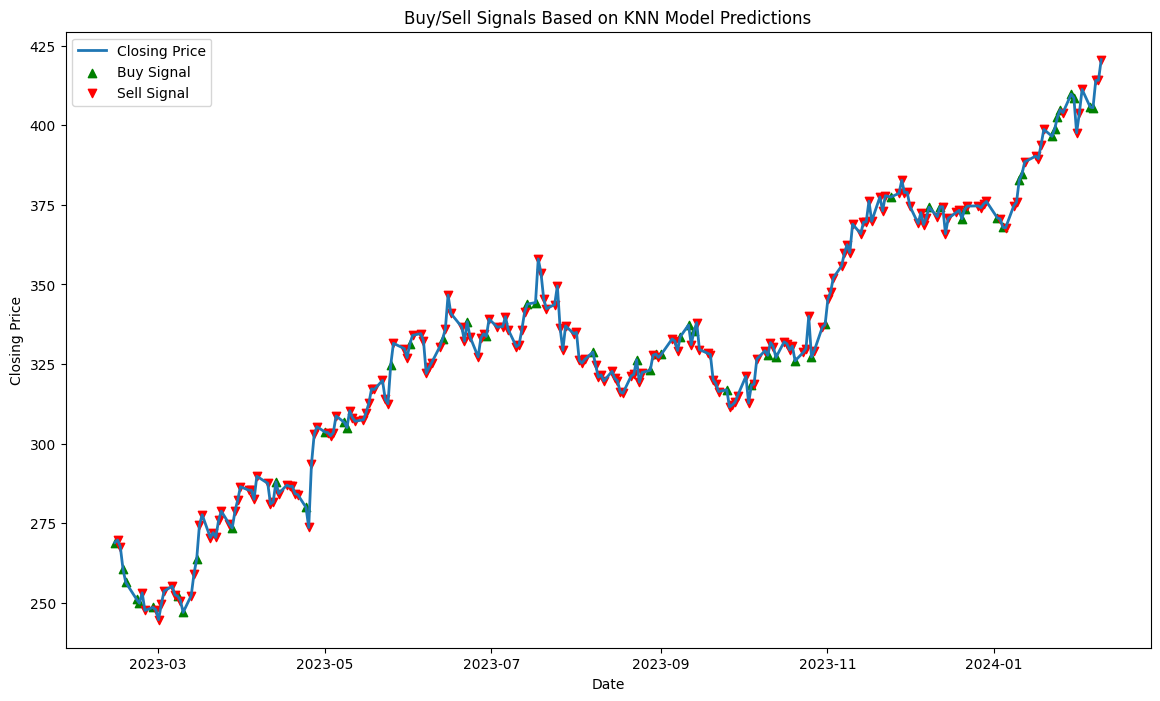

In [ ]:
# Predictions on the test set
y_pred = model.predict(X_test)

# Create a DataFrame for visualization
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

# Filter rows where the model predicts a buy signal
buy_signals = df_results[df_results['Predicted'] == 1]

# Filter rows where the model predicts a sell signal
sell_signals = df_results[df_results['Predicted'] == -1]

# Plotting the closing prices
plt.figure(figsize=(14, 8))
plt.plot(data.index[-250:], data['Close'][-250:], label='Closing Price', linewidth=2)

# Plotting buy signals
plt.scatter(buy_signals.index, data['Close'].loc[buy_signals.index], marker='^', color='g', label='Buy Signal')

# Plotting sell signals
plt.scatter(sell_signals.index, data['Close'].loc[sell_signals.index], marker='v', color='r', label='Sell Signal')

plt.title('Buy/Sell Signals Based on KNN Model Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


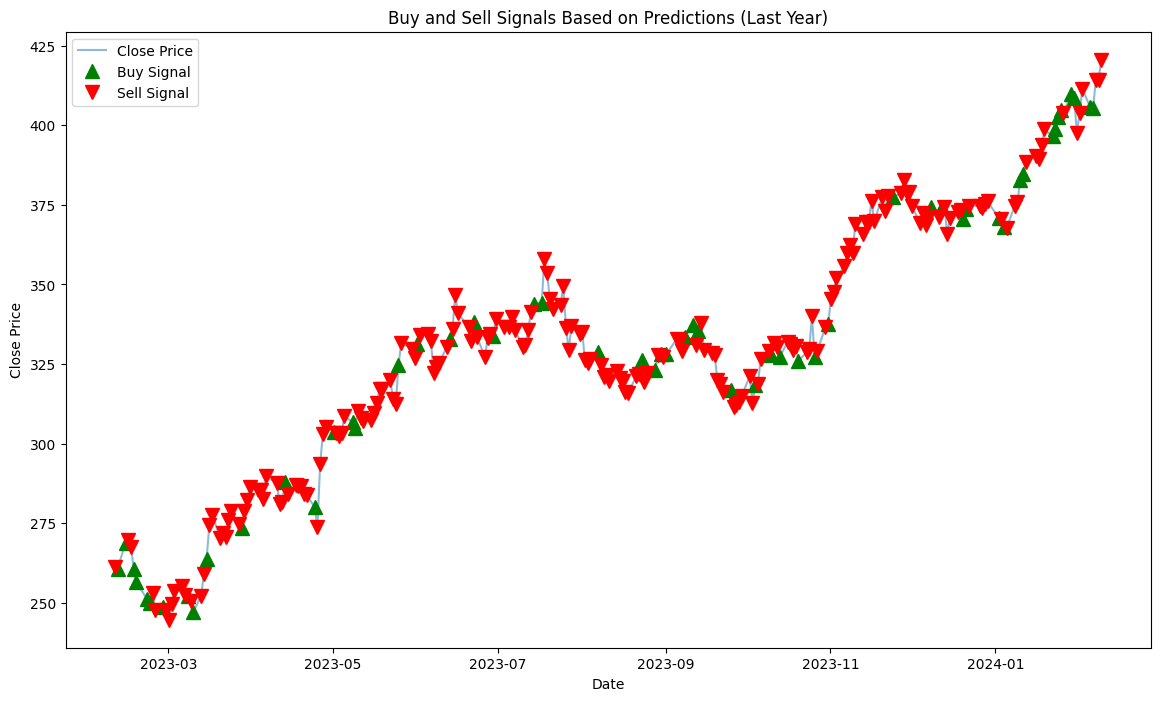

In [ ]:
# Assuming 'model' is your trained KNN model
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Concatenate the training and testing predictions for the entire dataset
all_predictions = np.concatenate([predictions_train, predictions_test])

# Create a new DataFrame with the predicted signals
signals_df = pd.DataFrame(index=data.index)
signals_df['Buy_Sell_Signal'] = all_predictions

# Filter signals for the last year
last_year_signals = signals_df[signals_df.index >= signals_df.index[-1] - pd.DateOffset(years=1)]

# Filter stock data for the last year
last_year_data = data[data.index >= data.index[-1] - pd.DateOffset(years=1)]

# Plot the Buy (1) and Sell (-1) signals for the last year
plt.figure(figsize=(14, 8))
plt.plot(last_year_data.index, last_year_data['Close'], label='Close Price', alpha=0.5)

# Plot Buy signals
plt.plot(last_year_signals[last_year_signals['Buy_Sell_Signal'] == 1].index,
         last_year_data['Close'][last_year_signals['Buy_Sell_Signal'] == 1],
         '^', markersize=10, color='g', label='Buy Signal')

# Plot Sell signals
plt.plot(last_year_signals[last_year_signals['Buy_Sell_Signal'] == -1].index,
         last_year_data['Close'][last_year_signals['Buy_Sell_Signal'] == -1],
         'v', markersize=10, color='r', label='Sell Signal')

plt.title('Buy and Sell Signals Based on Predictions (Last Year)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


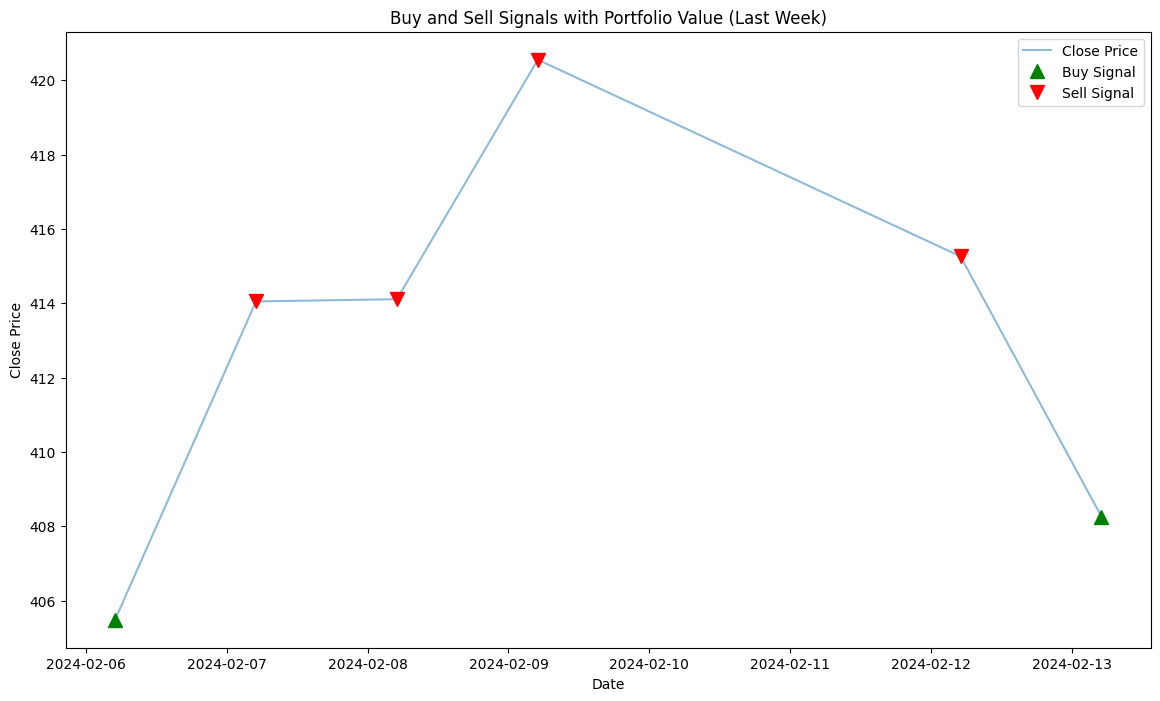

Initial Investment: $405.49
Total Profit after one week of trading: $8.56
Total Portfolio Value: $414.05


In [ ]:
# Assuming 'model' is your trained KNN model
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Concatenate the training and testing predictions for the entire dataset
all_predictions = np.concatenate([predictions_train, predictions_test])

# Create a new DataFrame with the predicted signals
signals_df = pd.DataFrame(index=data.index)
signals_df['Buy_Sell_Signal'] = all_predictions

# Filter signals for the last week
last_week_signals = signals_df[signals_df.index >= signals_df.index[-1] - pd.DateOffset(weeks=1)]

# Filter stock data for the last week
last_week_data = data[data.index >= data.index[-1] - pd.DateOffset(weeks=1)]

# Calculate profit and portfolio value based on buy and sell signals
profit = 0
portfolio_value = 0
position = 0  # 0: no position, 1: long position, -1: short position
buy_price = 0

for index, row in last_week_signals.iterrows():
    if row['Buy_Sell_Signal'] == 1 and position == 0:  # Buy signal and no current position
        buy_price = last_week_data.loc[index, 'Close']
        position = 1  # Set to long position
    elif row['Buy_Sell_Signal'] == -1 and position == 1:  # Sell signal and long position
        profit += last_week_data.loc[index, 'Close'] - buy_price
        position = 0  # Set to no position

# Calculate the initial investment (assuming one stock bought on the first buy signal)
initial_investment = last_week_data.iloc[0]['Close']

# Calculate the total portfolio value
portfolio_value = initial_investment + profit

# Plot the Buy (1) and Sell (-1) signals for the last week
plt.figure(figsize=(14, 8))
plt.plot(last_week_data.index, last_week_data['Close'], label='Close Price', alpha=0.5)

# Plot Buy signals
plt.plot(last_week_signals[last_week_signals['Buy_Sell_Signal'] == 1].index,
         last_week_data['Close'][last_week_signals['Buy_Sell_Signal'] == 1],
         '^', markersize=10, color='g', label='Buy Signal')

# Plot Sell signals
plt.plot(last_week_signals[last_week_signals['Buy_Sell_Signal'] == -1].index,
         last_week_data['Close'][last_week_signals['Buy_Sell_Signal'] == -1],
         'v', markersize=10, color='r', label='Sell Signal')

plt.title('Buy and Sell Signals with Portfolio Value (Last Week)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Print the total profit and portfolio value
print(f'Initial Investment: ${initial_investment:.2f}')
print(f'Total Profit after one week of trading: ${profit:.2f}')
print(f'Total Portfolio Value: ${portfolio_value:.2f}')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not 

Initial Portfolio Value: 100000
Final Portfolio Value: 150346.70733642578
Gain or Loss: 50346.70733642578


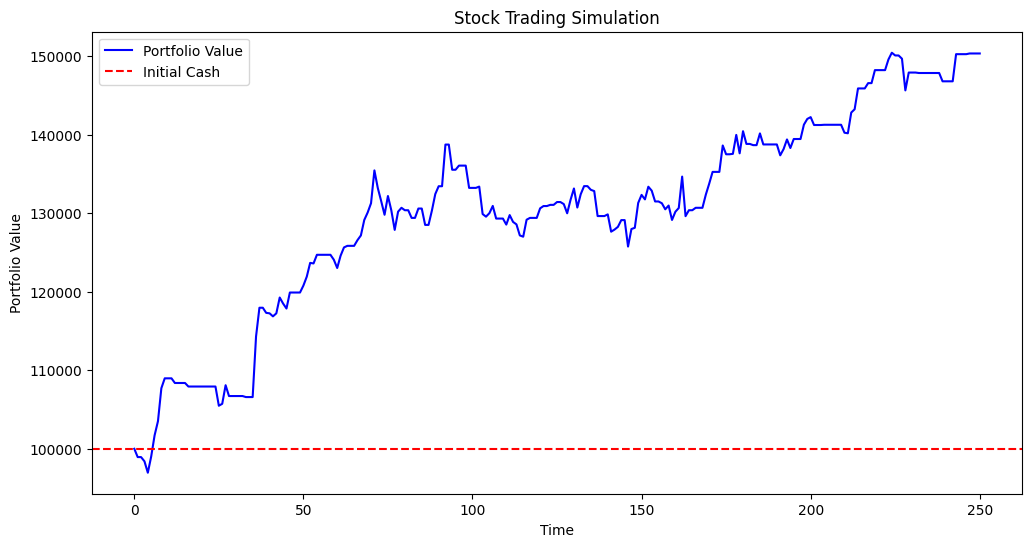

In [ ]:
import matplotlib.pyplot as plt

initial_cash = 100000  # Set your initial cash amount
cash = initial_cash
stocks_held = 0   # Number of stocks
portfolio_value = []

for index, row in X2_test.iterrows():
    newRow = row.drop('Close').copy()
    prediction = model.predict([newRow])[0]

    if prediction == 1:  # Buy signal
        while cash > row['Close']:
            stocks_held += 1
            cash -= row['Close']
    elif prediction == -1:  # Sell signal
        while stocks_held > 0:
            cash += row['Close']
            stocks_held -= 1

    portfolio_value.append(cash + stocks_held * row['Close'])

# Include the last portfolio value after the last data point
portfolio_value.append(cash + stocks_held * X2_test.iloc[-1]['Close'])

final_portfolio_value = portfolio_value[-1]  # Use the last value in the list
gain_or_loss = final_portfolio_value - initial_cash

print(f"Initial Portfolio Value: {initial_cash}")
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Gain or Loss: {gain_or_loss}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value', color='blue')
plt.axhline(y=initial_cash, color='r', linestyle='--', label='Initial Cash')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Stock Trading Simulation')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not 

Initial Portfolio Value: 100000
Final Portfolio Value: 157466.63246154794
Gain or Loss: 57466.63246154794


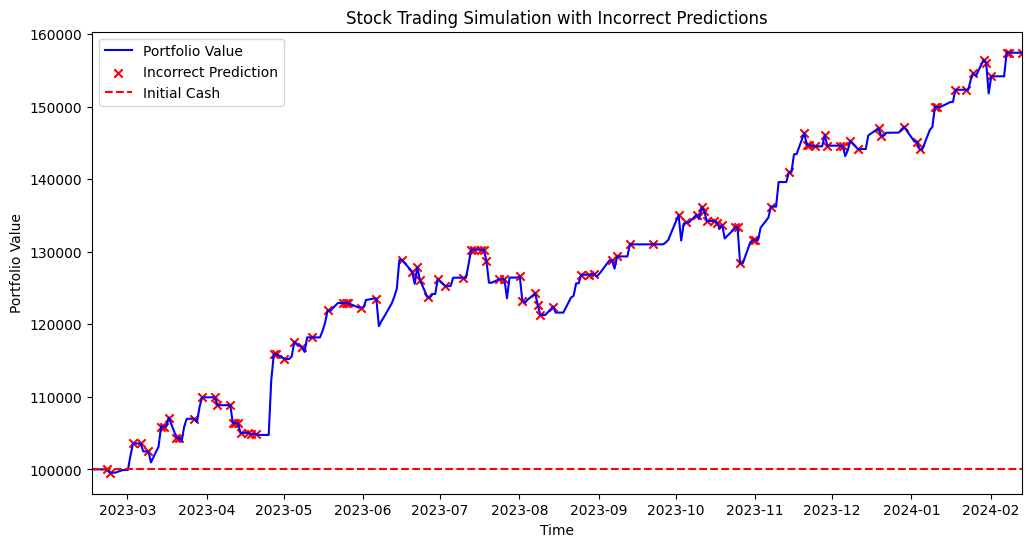

In [ ]:
import matplotlib.pyplot as plt

initial_cash = 100000  # Set your initial cash amount
cash = initial_cash
stocks_held = 0   # Number of stocks
portfolio_value = []
incorrect_predictions = []

for index, row in X2_test.iterrows():
    newRow = row.drop('Close').copy()
    prediction = model.predict([newRow])[0]

    if prediction == 1:  # Buy signal
        while cash > row['Close']:
            stocks_held += 1
            cash -= row['Close']
    elif prediction == -1:  # Sell signal
        while stocks_held > 0:
            cash += row['Close']
            stocks_held -= 1

    portfolio_value.append(cash + stocks_held * row['Close'])

    # Check if the prediction was incorrect
    actual_movement = int(y_test.loc[index])
    if prediction != actual_movement:
        incorrect_predictions.append((index, portfolio_value[-1]))

# Include the last portfolio value after the last data point
portfolio_value.append(cash + stocks_held * X2_test.iloc[-1]['Close'])

final_portfolio_value = portfolio_value[-1]  # Use the last value in the list
gain_or_loss = final_portfolio_value - initial_cash

print(f"Initial Portfolio Value: {initial_cash}")
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Gain or Loss: {gain_or_loss}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(X2_test.index, portfolio_value[:-1], label='Portfolio Value', color='blue')  # Exclude the last value for better visualization
incorrect_indices, incorrect_values = zip(*incorrect_predictions)
plt.scatter(incorrect_indices, incorrect_values, color='red', marker='x', label='Incorrect Prediction')

plt.axhline(y=initial_cash, color='r', linestyle='--', label='Initial Cash')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Stock Trading Simulation with Incorrect Predictions')
plt.legend()
plt.xlim(X2_test.index[0], X2_test.index[-1])  # Set the x-axis limits to the desired date range
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

Initial Portfolio Value: 100000
Final Portfolio Value: 142470.06253051758
Gain or Loss: 42470.06253051758


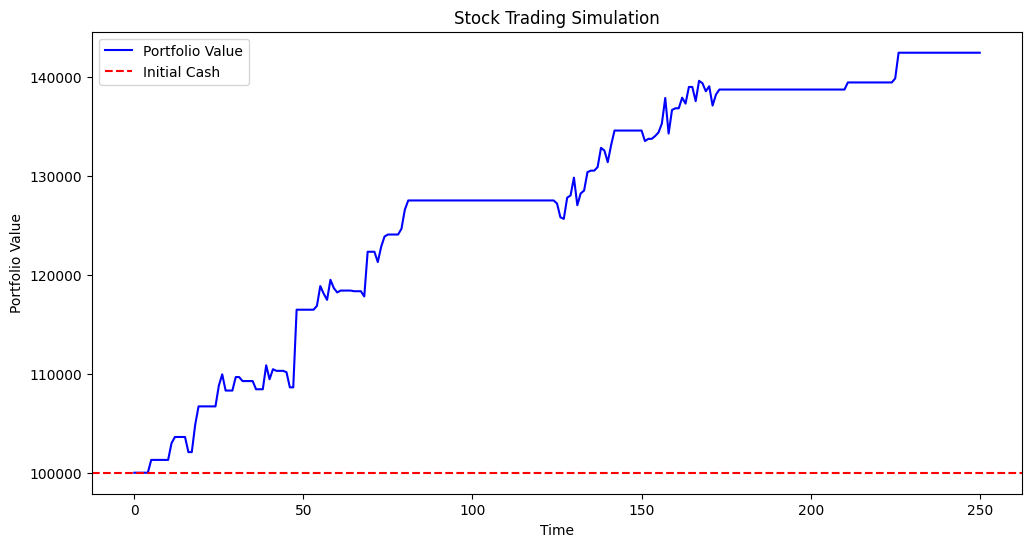

In [ ]:
#random forest model without "Volume" feature
import matplotlib.pyplot as plt

initial_cash = 100000  # Set your initial cash amount
cash = initial_cash
stocks_held = 0   # Number of stocks
portfolio_value = []

for index, row in X2_test.iterrows():
    newRow = row.drop('Close').copy()
    prediction = model3.predict([newRow])[0]

    if prediction == 1:  # Buy signal
        while cash > row['Close']:
            stocks_held += 1
            cash -= row['Close']
    elif prediction == -1:  # Sell signal
        while stocks_held > 0:
            cash += row['Close']
            stocks_held -= 1

    portfolio_value.append(cash + stocks_held * row['Close'])

# Include the last portfolio value after the last data point
portfolio_value.append(cash + stocks_held * X2_test.iloc[-1]['Close'])

final_portfolio_value = portfolio_value[-1]  # Use the last value in the list
gain_or_loss = final_portfolio_value - initial_cash

print(f"Initial Portfolio Value: {initial_cash}")
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Gain or Loss: {gain_or_loss}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value', color='blue')
plt.axhline(y=initial_cash, color='r', linestyle='--', label='Initial Cash')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Stock Trading Simulation')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

Initial Portfolio Value: 100000
Final Portfolio Value: 133589.15153503418
Gain or Loss: 33589.15153503418


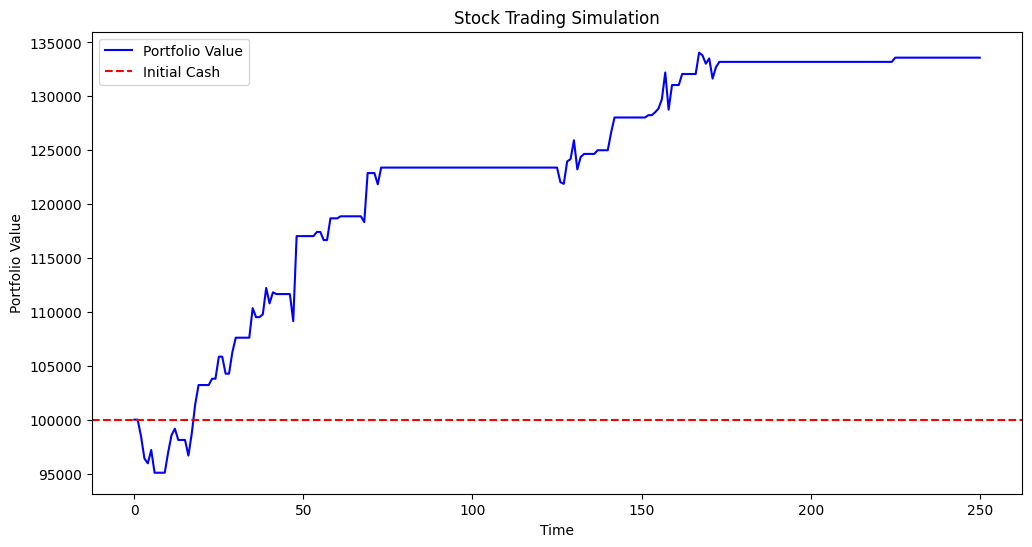

In [ ]:
#random forest model with "Volume" feature
import matplotlib.pyplot as plt

initial_cash = 100000  # Set your initial cash amount
cash = initial_cash
stocks_held = 0   # Number of stocks
portfolio_value = []

for index, row in X2_test.iterrows():
    newRow = row.drop('Close').copy()
    prediction = model3.predict([newRow])[0]

    if prediction == 1:  # Buy signal
        while cash > row['Close']:
            stocks_held += 1
            cash -= row['Close']
    elif prediction == -1:  # Sell signal
        while stocks_held > 0:
            cash += row['Close']
            stocks_held -= 1

    portfolio_value.append(cash + stocks_held * row['Close'])

# Include the last portfolio value after the last data point
portfolio_value.append(cash + stocks_held * X2_test.iloc[-1]['Close'])

final_portfolio_value = portfolio_value[-1]  # Use the last value in the list
gain_or_loss = final_portfolio_value - initial_cash

print(f"Initial Portfolio Value: {initial_cash}")
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Gain or Loss: {gain_or_loss}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value', color='blue')
plt.axhline(y=initial_cash, color='r', linestyle='--', label='Initial Cash')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Stock Trading Simulation')
plt.legend()
plt.show()
